In [1]:
import sys, os
import matplotlib.pyplot as plt
import pandas as pd

# Add the project root to the Python path (so we can import microgrid_sim)
module_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from microgrid_sim.components.storage import BatteryStorage

## Testing Battery Component

In [2]:
print("Initializing battery...")
battery = BatteryStorage(
    name="test_battery",
    capacity_kwh=100.0,        # 100 kWh capacity
    time_step_minutes=60,      # 1-hour steps
    initial_soc=0.5,
    min_soc=0.1,
    max_soc=0.9,
    max_charge_kw=50.0,
    max_discharge_kw=50.0,
    charge_efficiency=0.95,
    discharge_efficiency=0.95,
    degradation_cost_per_kwh=0.01  # $0.01 per kWh throughput (NEG cash flow = expense)
)
print(f"Initial SOC: {battery.get_soc():.2f}")

Initializing battery...
Initial SOC: 0.50


In [3]:
actions = [
    {"set_state": "ON"},                                   # 0: Turn ON
    {"set_state": "ON", "power_setpoint": -20.0},          # 1: Charge 20 kW
    {"set_state": "ON", "power_setpoint": -20.0},          # 2
    {"set_state": "ON", "power_setpoint": -20.0},          # 3
    {"set_state": "ON", "power_setpoint": -20.0},          # 4: Charge to max_soc (clamp)
    {"set_state": "ON", "power_setpoint": 30.0},           # 5: Discharge 30 kW
    {"set_state": "ON", "power_setpoint": 30.0},           # 6
    {"set_state": "ON", "power_setpoint": 30.0},           # 7
    {"set_state": "ON", "power_setpoint": 30.0},           # 8
    {"set_state": "ON", "power_setpoint": 30.0},           # 9: Discharge to min_soc (clamp)
    {"set_state": "ON", "power_setpoint": -100.0},         # 10: Try to overcharge -> clamp by max_charge_kw
    {"set_state": "OFF"}                                   # 11: Turn OFF
]
num_steps = len(actions)
num_steps

12

In [4]:
print("\nRunning simulation...")
results = {
    "t": [], "state": [], "soc": [],
    "power_setpoint": [], "actual_power": [], "cash_flow": []
}

for t in range(num_steps):
    action = actions[t]
    battery.step(t, action=action)

    results["t"].append(t)
    results["state"].append(battery.state.name)
    results["soc"].append(battery.get_soc())
    results["power_setpoint"].append(action.get("power_setpoint", 0.0))
    results["actual_power"].append(battery.get_power())
    results["cash_flow"].append(battery.get_cost())  # NEG=expense, POS=revenue

    print(f"t={t:02d} | State: {battery.state.name:<3} | "
          f"Setpoint: {action.get('power_setpoint', 0):>6.1f} kW | "
          f"Actual: {battery.get_power():>6.1f} kW | "
          f"SOC: {battery.get_soc():.3f} | "
          f"CashFlow: {battery.get_cost():+,.3f}")

print("Simulation complete.")
df = pd.DataFrame(results)


Running simulation...
t=00 | State: ON  | Setpoint:    0.0 kW | Actual:    0.0 kW | SOC: 0.500 | CashFlow: -0.000
t=01 | State: ON  | Setpoint:  -20.0 kW | Actual:  -20.0 kW | SOC: 0.690 | CashFlow: -0.200
t=02 | State: ON  | Setpoint:  -20.0 kW | Actual:  -20.0 kW | SOC: 0.880 | CashFlow: -0.200
t=03 | State: ON  | Setpoint:  -20.0 kW | Actual:   -2.1 kW | SOC: 0.900 | CashFlow: -0.021
t=04 | State: ON  | Setpoint:  -20.0 kW | Actual:   -0.0 kW | SOC: 0.900 | CashFlow: -0.000
t=05 | State: ON  | Setpoint:   30.0 kW | Actual:   30.0 kW | SOC: 0.584 | CashFlow: -0.300
t=06 | State: ON  | Setpoint:   30.0 kW | Actual:   30.0 kW | SOC: 0.268 | CashFlow: -0.300
t=07 | State: ON  | Setpoint:   30.0 kW | Actual:   16.0 kW | SOC: 0.100 | CashFlow: -0.160
t=08 | State: ON  | Setpoint:   30.0 kW | Actual:    0.0 kW | SOC: 0.100 | CashFlow: -0.000
t=09 | State: ON  | Setpoint:   30.0 kW | Actual:    0.0 kW | SOC: 0.100 | CashFlow: -0.000
t=10 | State: ON  | Setpoint: -100.0 kW | Actual:  -50.0 

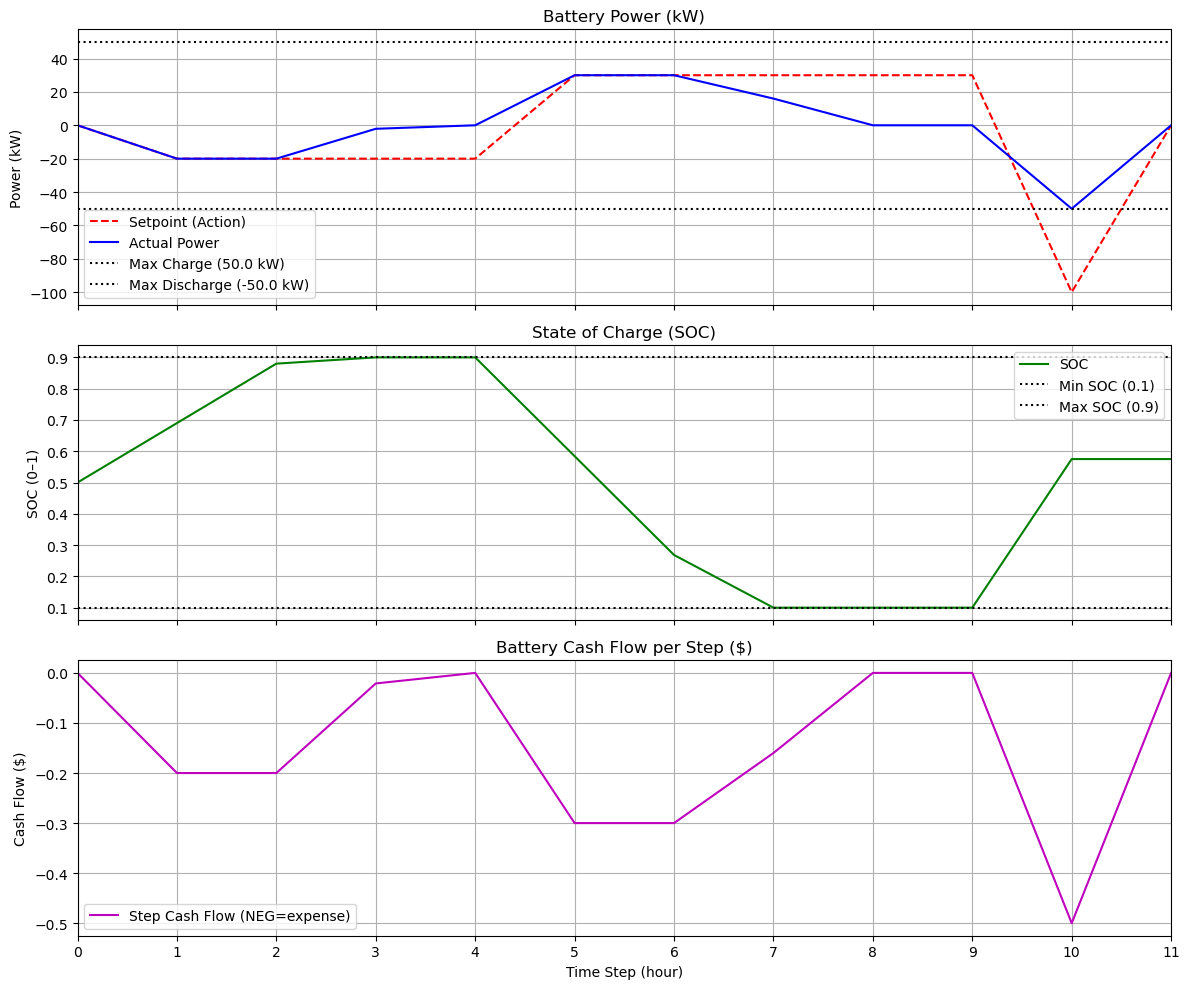

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Power
axs[0].set_title("Battery Power (kW)")
axs[0].plot(df["t"], df["power_setpoint"], "r--", label="Setpoint (Action)")
axs[0].plot(df["t"], df["actual_power"], "b-", label="Actual Power")
axs[0].axhline(-battery.params.max_charge_kw, color="k", linestyle=":", label=f"Max Charge ({battery.params.max_charge_kw} kW)")
axs[0].axhline(battery.params.max_discharge_kw, color="k", linestyle=":", label=f"Max Discharge ({-battery.params.max_discharge_kw} kW)")
axs[0].set_ylabel("Power (kW)")
axs[0].legend()
axs[0].grid(True)

# SOC
axs[1].set_title("State of Charge (SOC)")
axs[1].plot(df["t"], df["soc"], "g-", label="SOC")
axs[1].axhline(battery.params.min_soc, color="k", linestyle=":", label=f"Min SOC ({battery.params.min_soc})")
axs[1].axhline(battery.params.max_soc, color="k", linestyle=":", label=f"Max SOC ({battery.params.max_soc})")
axs[1].set_ylabel("SOC (0–1)")
axs[1].legend()
axs[1].grid(True)

# Cash flow
axs[2].set_title("Battery Cash Flow per Step ($)")
axs[2].plot(df["t"], df["cash_flow"], "m-", label="Step Cash Flow (NEG=expense)")
axs[2].set_xlabel("Time Step (hour)")
axs[2].set_ylabel("Cash Flow ($)")
axs[2].legend()
axs[2].grid(True)

# >>> Force x-axis to run from 0 to last step and use integer ticks
axs[2].set_xlim(0, num_steps - 1)
tick_step = max(1, num_steps // 10)  # adjust density as you like
axs[2].set_xticks(list(range(0, num_steps, tick_step)))

plt.tight_layout()
plt.show()

## Residential and Factory Loads

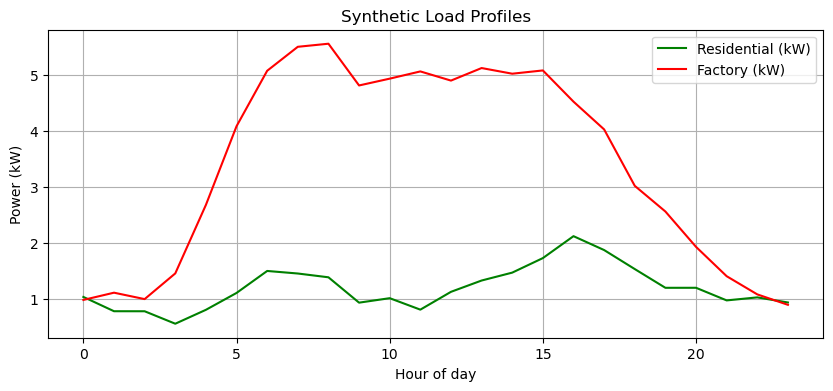

In [7]:
from microgrid_sim.components.loads import ResidentialLoad, FactoryLoad
import matplotlib.pyplot as plt
import numpy as np

res = ResidentialLoad("home", base_kw=1.5)
fac = FactoryLoad("factory", base_kw=5.0)

hours = np.arange(24)
res_kw = [res._sample_demand(h) for h in hours]
fac_kw = [fac._sample_demand(h) for h in hours]

plt.figure(figsize=(10,4))
plt.plot(hours, res_kw, 'g-', label='Residential (kW)')
plt.plot(hours, fac_kw, 'r-', label='Factory (kW)')
plt.xlabel('Hour of day')
plt.ylabel('Power (kW)')
plt.title('Synthetic Load Profiles')
plt.grid(True); plt.legend(); plt.show()
